# PROYECTO FINAL  -EDA

La empresa GoGreen Bikesharing se dedica al alquiler de bicicletas y posee datos tales como la cantidad de bicis alquiladas por usuarios registrados, la cantidad de alquileres realizados por usuarios puntuales, y la cantidad total. 

A estos datos se les añadió información meteorológica y el calendario de festivos.

Ahora buscan analizar cuáles son los aspectos que más influyen en la cantidad de bicis que van a alquilar en un día.

In [1]:
# Tratamiento de datos
import numpy as np
import pandas as pd
#import sidetable as stb

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import sidetable as stb

# Asunciones y Preprocesamiento
from scipy import stats
import math
from scipy.stats import levene
#import researchpy as rp
from sklearn.preprocessing import StandardScaler
import itertools
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import researchpy as rp # chi square

#Linear Regresion con Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = False

# EDA

In [2]:
df_bike = pd.read_csv("./bike_columnas_modificadas.csv", index_col=0)
df_bike.sample(6)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding,temp_interval,temp_interval_num,hum_interval,hum_interval_num,temp_interval_ord,hum_interval_ord,wind_interval,wind_num_encoding
597,598,2019-08-21,summer,1,8,21,0,2,1,1,26.6,30.1,67.4,4.875644,1081,5925,7006,3,high,"(22.14, 28.72]",high,"(58.32, 77.76]",4,4,very_low,very_low
234,235,2018-08-23,summer,0,8,23,0,2,1,1,26.3,30.3,45.5,9.833121,1281,4614,5895,3,high,"(22.14, 28.72]",medium,"(38.88, 58.32]",4,3,low,1
184,185,2018-04-07,spring,0,7,4,1,1,0,2,29.8,33.3,63.8,5.459106,3065,2978,6043,2,very_high,"(28.72, 35.3]",high,"(58.32, 77.76]",5,4,very_low,very_low
660,661,2019-10-23,autumn,1,10,23,0,2,1,1,22.3,26.5,64.2,6.334569,841,6625,7466,4,high,"(22.14, 28.72]",high,"(58.32, 77.76]",4,4,very_low,very_low
226,227,2018-08-15,summer,0,8,15,0,1,1,1,27.3,30.8,71.2,13.999918,775,3563,4338,3,high,"(22.14, 28.72]",high,"(58.32, 77.76]",4,4,low,1
440,441,2019-03-17,winter,1,3,17,0,6,0,2,21.1,25.3,75.6,7.417168,3155,4681,7836,1,medium,"(15.56, 22.14]",high,"(58.32, 77.76]",3,4,very_low,very_low


### ELIMINAMOS COLUMNAS SOBRANTES

Después de este proceso de exploración y limpieza decidimos borrar las columnas siguientes:
- Atemp (y sus derivadas) pues sus datos son muy similiares a los de temperatura. Usaremos esta segunda.
- "Dtday": pues ya hemos desglosado esa columna en día/mes/año
- "Instant": pues funciona como un índice, y usaremos el índice del dataframe
- "Season" no podemos hacer con ella nada más a partir de este momento


In [3]:
df_bike = df_bike.drop(columns= ['instant', 'dteday','season','atemp'], axis=1 )

In [4]:
df_bike.head(2)

,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt,season_encoding,temp_interval,temp_interval_num,hum_interval,hum_interval_num,temp_interval_ord,hum_interval_ord,wind_interval,wind_num_encoding
0,0,1,1,0,6,0,2,14.1,80.6,10.749882,331,654,985,1,low,"(8.98, 15.56]",very_high,"(77.76, 97.2]",2,5,low,1
1,0,1,2,0,0,0,2,14.9,69.6,16.652113,131,670,801,1,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4,medium,2


### REORDENAMOS LAS COLUMNAS:

In [5]:
cols = ['casual', 'registered', 'cnt', 'season_encoding', 'yr', 'mnth', 'day', 'holiday', 'weekday', 'workingday',
                            'weathersit', 'temp', 'temp_interval', 'temp_interval_ord', "temp_interval_num", 'hum', 'hum_interval', 'hum_interval_num','hum_interval_ord', 'windspeed', 'wind_interval', 'wind_num_encoding']
df_bike = df_bike.reindex(columns=cols)

In [6]:
df_bike.head(2)

,casual,registered,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,temp_interval,temp_interval_ord,temp_interval_num,hum,hum_interval,hum_interval_num,hum_interval_ord,windspeed,wind_interval,wind_num_encoding
0,331,654,985,1,0,1,1,0,6,0,2,14.1,low,2,"(8.98, 15.56]",80.6,very_high,"(77.76, 97.2]",5,10.749882,low,1
1,131,670,801,1,0,1,2,0,0,0,2,14.9,low,2,"(8.98, 15.56]",69.6,high,"(58.32, 77.76]",4,16.652113,medium,2


### Data Frame con seleccion de columnas para continuar

    El siguiente DF que nos sirve para comtinuar no tiene porque tener en sus columnas los rangos. Los rangos nos han servido al principio para la visualización.

In [7]:
df_bike= df_bike.drop(['temp_interval_num','hum_interval_num'], axis=1)

# DATAFRAME FINAL para contuniar con EDA

In [8]:
df_bike.head()

,casual,registered,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,temp_interval,temp_interval_ord,hum,hum_interval,hum_interval_ord,windspeed,wind_interval,wind_num_encoding
0,331,654,985,1,0,1,1,0,6,0,2,14.1,low,2,80.6,very_high,5,10.749882,low,1
1,131,670,801,1,0,1,2,0,0,0,2,14.9,low,2,69.6,high,4,16.652113,medium,2
2,120,1229,1349,1,0,1,3,0,1,1,1,8.1,very_low,1,43.7,medium,3,16.636703,medium,2
3,108,1454,1562,2,0,1,4,0,2,1,1,8.2,very_low,1,59.0,high,4,10.739832,low,1
4,82,1518,1600,2,0,1,5,0,3,1,1,9.3,low,2,43.7,medium,3,12.522300,low,1


### ¿QUE VEMOS AQUI? 

In [9]:
df_bike.describe().T

,count,mean,std,min,25%,50%,75%,max
casual,730.0,849.249315,686.479875,2.000000,316.25000,717.000000,1096.500000,3410.000000
registered,730.0,3658.757534,1559.758728,20.000000,2502.25000,3664.500000,4783.250000,6946.000000
cnt,730.0,4508.006849,1936.011647,22.000000,3169.75000,4548.500000,5966.000000,8714.000000
season_encoding,730.0,2.509589,1.117533,1.000000,2.00000,3.000000,4.000000,4.000000
yr,730.0,0.500000,0.500343,0.000000,0.00000,0.500000,1.000000,1.000000
mnth,730.0,6.526027,3.450215,1.000000,4.00000,7.000000,10.000000,12.000000
day,730.0,15.720548,8.802278,1.000000,8.00000,16.000000,23.000000,31.000000
holiday,730.0,0.028767,0.167266,0.000000,0.00000,0.000000,0.000000,1.000000
weekday,730.0,2.997260,2.006161,0.000000,1.00000,3.000000,5.000000,6.000000
workingday,730.0,0.683562,0.465405,0.000000,0.00000,1.000000,1.000000,1.000000


### ¿CUANTOS NULOS HAY? --> NO TENEMOS

In [10]:
df_bike.isnull().sum()

casual               0
registered           0
cnt                  0
season_encoding      0
yr                   0
mnth                 0
day                  0
holiday              0
weekday              0
workingday           0
weathersit           0
temp                 0
temp_interval        0
temp_interval_ord    0
hum                  0
hum_interval         0
hum_interval_ord     0
windspeed            0
wind_interval        0
wind_num_encoding    0
dtype: int64

### ¿CUALES SON CATEGORICAS Y/O NUMÉRCIAS? ¿NECESITO CAMBIARLAS?

    Si , necesitamos poner las que tienen ENCODING como categorias, ya que son categorias.

In [11]:
# Primero vemos que tipo de categoria tienen por defecto
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   casual             730 non-null    int64  
 1   registered         730 non-null    int64  
 2   cnt                730 non-null    int64  
 3   season_encoding    730 non-null    int64  
 4   yr                 730 non-null    int64  
 5   mnth               730 non-null    int64  
 6   day                730 non-null    int64  
 7   holiday            730 non-null    int64  
 8   weekday            730 non-null    int64  
 9   workingday         730 non-null    int64  
 10  weathersit         730 non-null    int64  
 11  temp               730 non-null    float64
 12  temp_interval      730 non-null    object 
 13  temp_interval_ord  730 non-null    int64  
 14  hum                730 non-null    float64
 15  hum_interval       730 non-null    object 
 16  hum_interval_ord   730 non

In [12]:
#Mostramos este head para ver poco a poco que categorias debemos cambiar
df_bike.head(2)

,casual,registered,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,temp_interval,temp_interval_ord,hum,hum_interval,hum_interval_ord,windspeed,wind_interval,wind_num_encoding
0,331,654,985,1,0,1,1,0,6,0,2,14.1,low,2,80.6,very_high,5,10.749882,low,1
1,131,670,801,1,0,1,2,0,0,0,2,14.9,low,2,69.6,high,4,16.652113,medium,2


In [13]:
#Cambiamos las categorias
df_bike['season_encoding'] = df_bike['season_encoding'].astype('object')  
df_bike['yr'] = df_bike['yr'].astype('object')  
df_bike['mnth'] = df_bike['mnth'].astype('object')  
df_bike['day'] = df_bike['day'].astype('object')  
df_bike['holiday'] = df_bike['holiday'].astype('object')  
df_bike['weekday'] = df_bike['weekday'].astype('object')  
df_bike['workingday'] = df_bike['workingday'].astype('object')  
df_bike['weathersit'] = df_bike['weathersit'].astype('object')  
df_bike['temp_interval_ord'] = df_bike['temp_interval_ord'].astype('object')  
df_bike['hum_interval_ord'] = df_bike['hum_interval_ord'].astype('object')  
df_bike['wind_num_encoding'] = df_bike['wind_num_encoding'].astype('object')  


In [14]:
# Vemos que ya se han cambiado las categorias y ahora podemos seguir con el proceso
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   casual             730 non-null    int64  
 1   registered         730 non-null    int64  
 2   cnt                730 non-null    int64  
 3   season_encoding    730 non-null    object 
 4   yr                 730 non-null    object 
 5   mnth               730 non-null    object 
 6   day                730 non-null    object 
 7   holiday            730 non-null    object 
 8   weekday            730 non-null    object 
 9   workingday         730 non-null    object 
 10  weathersit         730 non-null    object 
 11  temp               730 non-null    float64
 12  temp_interval      730 non-null    object 
 13  temp_interval_ord  730 non-null    object 
 14  hum                730 non-null    float64
 15  hum_interval       730 non-null    object 
 16  hum_interval_ord   730 non

    Selecionamos variables numericas

In [15]:
numericas = df_bike.select_dtypes(include = np.number)
numericas

,casual,registered,cnt,temp,hum,windspeed
0,331,654,985,14.1,80.6,10.749882
1,131,670,801,14.9,69.6,16.652113
2,120,1229,1349,8.1,43.7,16.636703
3,108,1454,1562,8.2,59.0,10.739832
4,82,1518,1600,9.3,43.7,12.522300
...,...,...,...,...,...,...
725,247,1867,2114,10.4,65.3,23.458911
726,644,2451,3095,10.4,59.0,10.416557
727,159,1182,1341,10.4,75.3,8.333661
728,364,1432,1796,10.5,48.3,23.500518


    Seleccionamos variables categóricas

In [16]:
categoricas = df_bike.select_dtypes(include='object')
categoricas

,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp_interval,temp_interval_ord,hum_interval,hum_interval_ord,wind_interval,wind_num_encoding
0,1,0,1,1,0,6,0,2,low,2,very_high,5,low,1
1,1,0,1,2,0,0,0,2,low,2,high,4,medium,2
2,1,0,1,3,0,1,1,1,very_low,1,medium,3,medium,2
3,2,0,1,4,0,2,1,1,very_low,1,high,4,low,1
4,2,0,1,5,0,3,1,1,low,2,medium,3,low,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,4,1,12,27,0,4,1,2,low,2,high,4,high,3
726,4,1,12,28,0,5,1,2,low,2,high,4,low,1
727,4,1,12,29,0,6,0,2,low,2,high,4,low,1
728,4,1,12,30,0,0,0,1,low,2,medium,3,high,3


### OUTLIERS, detectarlos y que hacer con ellos.

In [17]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} 
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df_bike[col], 25)
        Q3 = np.nanpercentile(df_bike[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
    
    return dicc_indices 

In [18]:
lista_columnas = list(numericas.columns)
lista_columnas

['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

In [19]:
ind = detectar_outliers(lista_columnas, df_bike)
print(ind)

{'casual': [148, 183, 184, 196, 246, 281, 440, 446, 454, 455, 461, 468, 469, 475, 489, 496, 503, 504, 510, 511, 512, 517, 518, 524, 531, 532, 538, 539, 549, 559, 567, 580, 594, 608, 609, 616, 622, 629, 630, 636, 643, 657, 664, 679], 'hum': [49, 68], 'windspeed': [44, 49, 93, 94, 292, 382, 407, 420, 431, 432, 449, 665, 720]}


<AxesSubplot:>

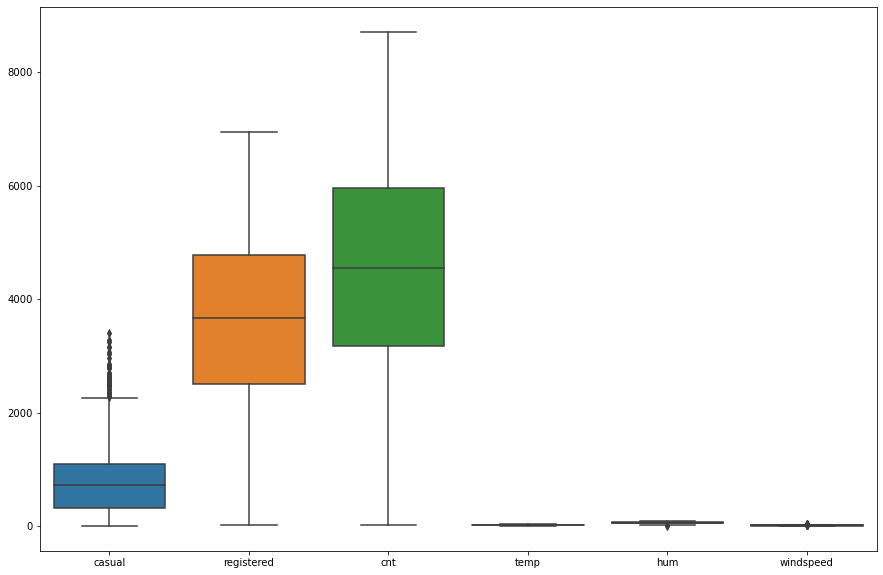

In [20]:
plt.figure(figsize= (15, 10))
sns.boxplot(data = numericas)

### Son pocos Outliers , pero por que tiene "cnt" ?

    Tiene su mayoria de datos de 0 a 2000, de 2000 a 4000 tiene Outliers por que no corresponde con la distribución normal según cnt o registered.
    Pero no debemos modificar estos Outliers. Son datos reales que deben entrar así en el modelo, si no , no sería realista modificar el número de reservas, es lo que estamos intentado responder.

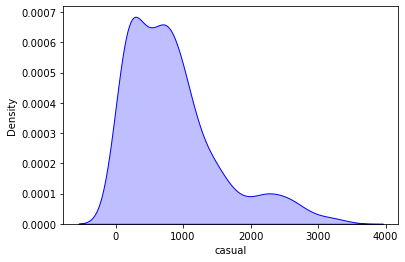

In [21]:
sns.distplot(
    df_bike.casual, 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});

In [22]:
df_bike.head()

,casual,registered,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,temp_interval,temp_interval_ord,hum,hum_interval,hum_interval_ord,windspeed,wind_interval,wind_num_encoding
0,331,654,985,1,0,1,1,0,6,0,2,14.1,low,2,80.6,very_high,5,10.749882,low,1
1,131,670,801,1,0,1,2,0,0,0,2,14.9,low,2,69.6,high,4,16.652113,medium,2
2,120,1229,1349,1,0,1,3,0,1,1,1,8.1,very_low,1,43.7,medium,3,16.636703,medium,2
3,108,1454,1562,2,0,1,4,0,2,1,1,8.2,very_low,1,59.0,high,4,10.739832,low,1
4,82,1518,1600,2,0,1,5,0,3,1,1,9.3,low,2,43.7,medium,3,12.522300,low,1


### Guardamos EDA

In [24]:
df_bike.to_csv("EDA__parte_3.csv")